# Membership Attack to Keras Model of MNIST Dataset

In [1]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train/255, x_test/255  # normalize 0~1

print('Train samples:', len(x_train))
print('Test samples:', len(x_test))

Train samples: 60000
Test samples: 10000


Now we are going to split the data into 2 disjoints sets:
+ One to train the target model
+ The other to use as data from the same distribution to train our shadow models

In [3]:
x_target_train, x_attack_train, y_target_train, y_attack_train = train_test_split(x_train, y_train, test_size=0.5)
x_target_test, x_attack_test, y_target_tes, y_attack_test = train_test_split(x_test, y_test, test_size=0.5)

print('Target Train samples:', len(x_target_train))
print('Target Test samples:', len(x_target_test))
print('Attack Train samples:', len(x_attack_train))
print('Attack Test samples:', len(x_attack_test))

Target Train samples: 30000
Target Test samples: 5000
Attack Train samples: 30000
Attack Test samples: 5000


### Train the target model

In [4]:
target_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

train_op = tf.train.AdamOptimizer(1e-4)

target_model.compile(optimizer=train_op,
              loss='sparse_categorical_crossentropy',
              metric=['accuracy'])

In [5]:
target_model.fit(x_target_train, y_target_train, epochs=5, use_multiprocessing=True, workers=6)

Epoch 1/5
30000/30000 [==============================] - 2s 65us/step - loss: 0.6169
Epoch 2/5
30000/30000 [==============================] - 2s 63us/step - loss: 0.2840
Epoch 3/5
30000/30000 [==============================] - 2s 62us/step - loss: 0.2271
Epoch 4/5
30000/30000 [==============================] - 2s 62us/step - loss: 0.1921
Epoch 5/5
30000/30000 [==============================] - 2s 62us/step - loss: 0.1640


In [6]:
res = target_model.predict_proba(x_test)

In [7]:
print('Model accuracy:', sum(np.argmax(res, axis=1) == y_test) / len(y_test))

Model accuracy: 0.9538


### Train the Shadow model

In [4]:
from mblearn import ShadowModels

In [5]:
shadow_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

train_op = tf.train.AdamOptimizer(1e-4)
shadow_model.compile(optimizer=train_op,
              loss='sparse_categorical_crossentropy',
              metric=['accuracy'])

In [6]:
shm = ShadowModels(x_attack_train,
                   y_attack_train,
                   n_models=6,
                   target_classes=10,
                   learner=shadow_model,
                   epochs=5,
                   verbose=0)

ValueError: could not broadcast input array from shape (499,784) into shape (499)

In [15]:
import matplotlib.pyplot as plt

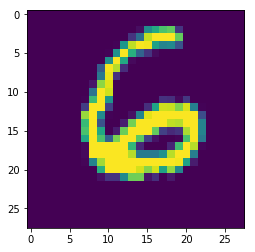

In [16]:
plt.imshow(x_attack_train[0])

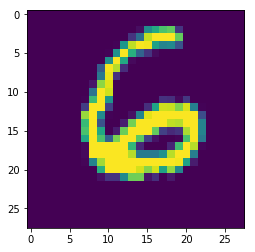

In [18]:
plt.imshow(x_attack_train.reshape(x_attack_train.shape[0],-1)[0].reshape(28,28))

In [35]:
x_attack_train[0,:].ndim

2

### Train Attack models

In [21]:
from mblearn import AttackModels
from sklearn.ensemble import RandomForestClassifier

In [22]:
rf_attack = RandomForestClassifier(n_estimators=100)

In [23]:
attacker = AttackModels(target_classes=10, attack_learner=rf_attack)

In [24]:
attacker.fit(shm.results, learner_kwargs={})

ValueError: Found array with 0 sample(s) (shape=(0, 10)) while a minimum of 1 is required.